# HbT pipeline

In [264]:
# -*- coding: utf-8 -*-
"""
Created on Thu Jan 12 13:38:43 2023

@author: vincent chouinard
"""
import os
from tqdm import tqdm
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from skimage.filters import threshold_local
import imageio
import sys
import imageio.v2 as imageio
from PyQt5.QtWidgets import QFileDialog, QApplication
import tifffile as tiff
from scipy import stats, ndimage


module_path = r'/Users/vincentchouinard/Documents/GitHub/Widefield-Imaging-analysis'
sys.path.insert(1,module_path)
from WFmovie import WFmovie, create_channel, regress_timeseries, save_figures_as_gif


module_path_chouine = r'/Users/vincentchouinard/Documents/GitHub/WideField'
sys.path.insert(2, module_path_chouine)
from MIFFE import *

**NOTE:** This notebook requires .tif green and red data for **convert_to_hb** function. If data is not already in .tif, it can be opened and saved as .tif following the **create_movies** and **generate_data_folder** pipeline.

## 1. Opens, corrects and loads data in folderpath

In [265]:
folderpath = "/Users/vincentchouinard/Documents/Maitrise/Data/_CVR_dataset/CVR_M34_18juil"

##### Correction, opening and baseline parameters 

In [266]:
channels_exist = False            # If True: channels already exist and no need to create channels.
channels = ['green', 'red']       # 'green', 'red', 'blue', 'ir'.
data_type = 'corrected'           # Loads corrected .tif if 'corrected', or raw data .tif if 'raw'.
baseline_time = 30                # Baseline seconds at beginning of acquisition.

In [267]:
movies = create_movies(folderpath, channels = channels , channels_exist = channels_exist, stim_path = False, memmap=True)
freq = int(movies[0].freq / movies[0].nchannels)

if data_type == "corrected":
    for i in range(len(channels)):
        generate_data_folder(movies[i], folderpath, channels[i], tif = True, CaImAn = True, numpy = False)
    g_path = folderpath + "/Correction/corrected_green_movie.tif"
    r_path = folderpath + "/Correction/corrected_red_movie.tif"

elif data_type == "raw":
    g_path = folderpath + "/Correction/green_movie.tif"
    r_path = folderpath + "/Correction/red_movie.tif"

data_path: /Users/vincentchouinard/Documents/Maitrise/Data/_CVR_dataset/CVR_M34_18juil
stim_path: False
channels: ['green', 'red']
channels_exist: False
binning: False
normalize: False
gaussian_filter: False
gaussian_std: 1
temp_med_filter: False
temp_med_width: 3
substract_background: False
background_path: None


KeyboardInterrupt: 

## 2. Creates Hb_data folder in which dHbO/dHbR/dHbT will be saved in .tif

In [6]:
# Directory
directory = "Hb_data"
parent_dir = folderpath
  
# Path
save_path = os.path.join(parent_dir, directory)

if not os.path.exists(save_path):
    # Create the directory
    os.mkdir(save_path)
    print("Directory '% s' created." % directory)

else:
    print("Directory '% s' already exists." % directory)

Directory 'Hb_data' created.


In [7]:
os.chdir(module_path)
convert_to_hb(g_path , r_path , save_path , baseline = [0 , (freq*baseline_time)] , bin_size=2 )
os.chdir(module_path_chouine)
print("Done! dHbO/dHbR/dHbT .tifs are now saved in Hb_data.")

100%|███████████████████████████████████████| 2250/2250 [00:25<00:00, 88.46it/s]

Done! dHbO/dHbR/dHbT .tifs are now saved in Hb_data.


## Analysis

In [268]:
dHbT_path = search_path(path_type="file")

You chose: /Users/vincentchouinard/Documents/Maitrise/Data/_CVR_dataset/CVR_M34_18juil/Hb_data/dHbT.tif


In [211]:
im = tiff.imread(dHbT_path)

In [212]:
CVR_stim = np.zeros(dHbO_array.data.shape[0])

In [213]:
CVR_stim[90:270] = 0.5
CVR_stim[450:630] = 0.5
CVR_stim[810:990] = 0.5
CVR_stim[1170:1350] = 1
CVR_stim[1530:1710] = 1
CVR_stim[1890:]

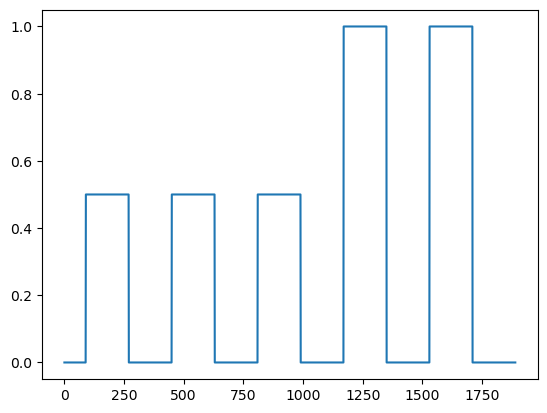

In [214]:
plt.plot(CVR_stim)
plt.show()

In [215]:
from scipy.stats import gamma

In [216]:
HRF = gamma.pdf(t, 6) + -0.5*gamma.pdf(t,10)

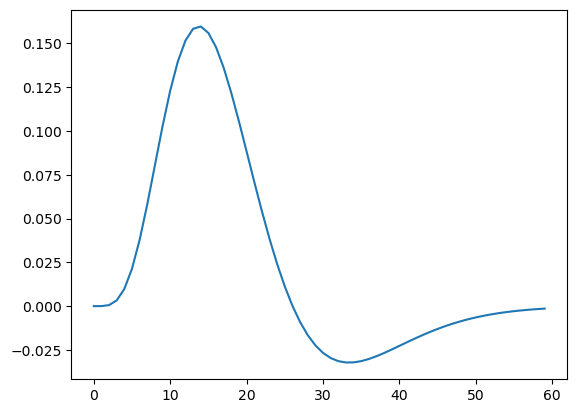

In [217]:
plt.plot(HRF)
plt.show()

In [218]:
from scipy.signal import convolve

In [219]:
regressor = convolve(CVR_stim, HRF)[:len(CVR_stim)]

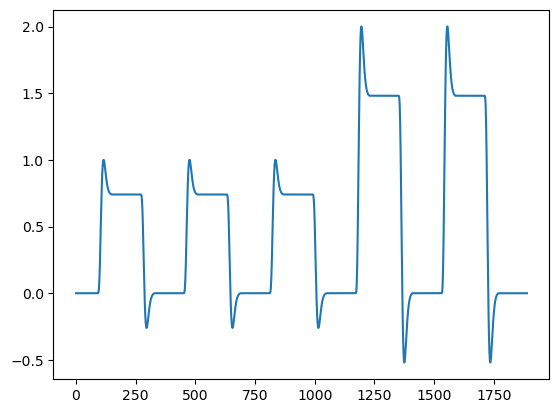

In [220]:
plt.plot(regressor)

In [221]:
def exponential(t, tau=10):
    return np.exp(-(t / tau))

In [222]:
kernel = exponential(t)

In [223]:
regressor = convolve(CVR_stim, kernel)[:len(CVR_stim)]
regressor /= np.max(regressor)

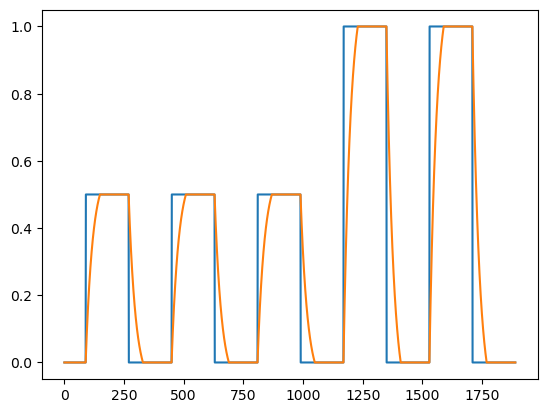

In [224]:
plt.plot(CVR_stim)
plt.plot(regressor)

In [225]:
signal = im[:,130:150, 120:140]

In [226]:
signal = np.mean(signal, axis=(1,2))

In [227]:
from scipy.ndimage import gaussian_filter1d, minimum_filter1d

In [228]:
def baseline_minfilter(signal, window=300, sigma1=5, sigma2=100, debug=False):
    signal_flatstart = np.copy(signal)
    signal_flatstart[0] = signal[1]
    smooth = gaussian_filter1d(signal_flatstart, sigma1)
    mins = minimum_filter1d(smooth, window)
    baseline = gaussian_filter1d(mins, sigma2)
    if debug:
        debug_out = np.asarray([smooth, mins, baseline])
        return debug_out
    else:
        return baseline

In [229]:
baseline = baseline_minfilter(signal, sigma1 = 3, sigma2=200)

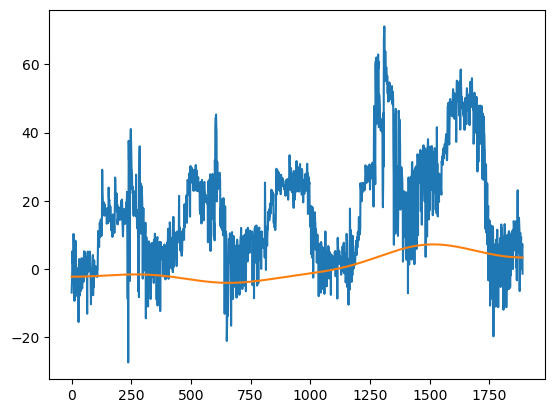

In [230]:
plt.plot(signal)
plt.plot(baseline)
plt.show()

In [231]:
detrended = signal-baseline

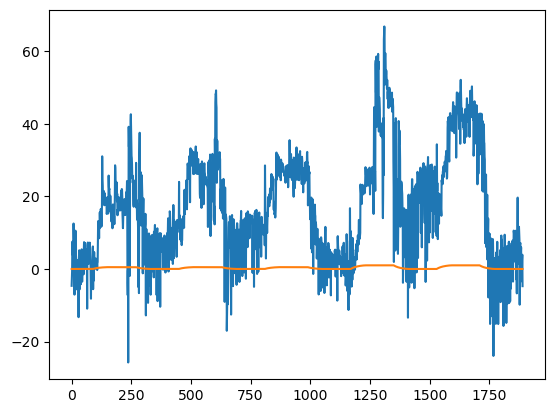

In [233]:
plt.plot(detrended)
plt.plot(regressor)

In [234]:
def fit_signal(signal1, signal2):
    """Fit one-dimensional signal1 to signal2 using simple inversion of a linear matrix equation.
    Returns: fit coefficients (a, b) and fit signal a * signal1 + b."""
    signal1 = np.expand_dims(signal1.flatten(), axis=1)  # (N x 1) vector
    signal2 = np.expand_dims(signal2.flatten(), axis=1)  # (N x 1) vector
    vectors = np.concatenate([signal1, np.ones((signal1.shape[0], 1))], axis=1)  # (N x 2) matrix
    coeffs = (np.linalg.pinv(vectors) @ signal2).flatten()
    fit = coeffs[0] * signal1 + coeffs[1]
    return coeffs, fit

In [235]:
_, fit = fit_signal(regressor, detrended)

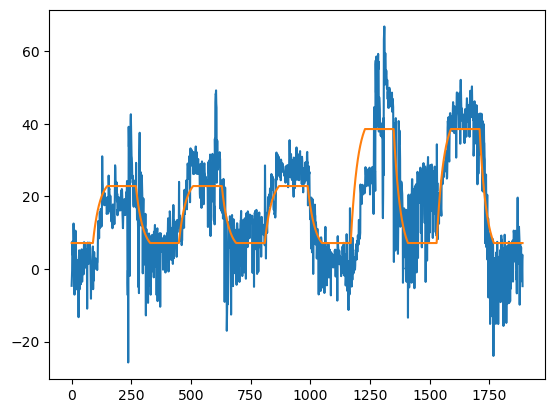

In [236]:
plt.plot(detrended)
plt.plot(fit)

In [237]:
norm_detrended = detrended / np.max(detrended)

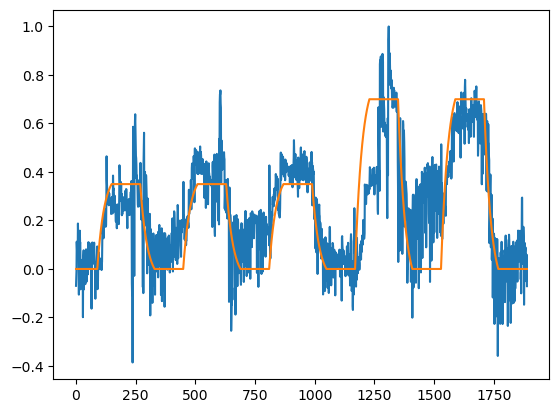

In [238]:
plt.plot(norm_detrended)
plt.plot(regressor*0.7)

## Next step, double boucle sur ton image, pearson_R, pas compliqué là... 

In [242]:
im.shape

(1890, 308, 245)

In [245]:
corr = np.zeros((im.shape[1], im.shape[2]))
corr.shape

(308, 245)

In [246]:
for x in tqdm(range(im.shape[2])):
    for y in range(im.shape[1]):
        corr[y,x] = np.corrcoef(regressor,im[:,y,x])[0,1]

100%|█████████████████████████████████████████| 245/245 [00:11<00:00, 21.04it/s]


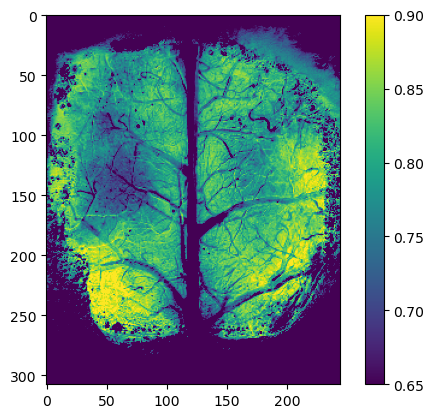

In [263]:
plt.imshow(corr, vmin = 0.65 , vmax = 0.9)
plt.colorbar()

## Hétérogénéité potentiellement dûe au behavior . Mais, pouquoi c'est les veines sont les moins corrélées ? Intéressant